# Modelling and Evaluation Notebook

## Objectives
* Answer Business Requirement 2:
    * The client is interested to know if a cherry leaf has powdery mildew or not.

## Inputs
    * inputs/cherry_leaves/cherry-leaves/train
    * inputs/cherry_leaves/cherry-leaves/test
    * inputs/cherry_leaves/cherry-leaves/validation
    * Image shape embeddings

## Outputs 
    * Images distribution plot in train, validation and test set
    * Image augmentation
    * Class indices to change prediction inference in labels
    * Machine learning model creation and training
    * Save model
    * Learning curve plot for model performance
    * Model evaluation on pickle file
    * Prediction on the random image file
    
## Additional Comments | Insights | Conclusions

# Set Data Directory

## Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

## Set Working Directory

In [2]:
current_dir = os.getcwd()
current_dir

'/workspace/NEW-CHERRY-LEAVES/jupyter_notebooks'

In [3]:
os.chdir('/workspace/NEW-CHERRY-LEAVES')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/NEW-CHERRY-LEAVES'

## Set Input Directories
Set train, validation and test paths

In [5]:
my_data_dir = 'inputs/cherry_leaves/cherry-leaves'
test_path = my_data_dir + '/test'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'

## Set Output Directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


### Set labels

In [7]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
    )

Project Labels: ['healthy', 'powdery_mildew']


## Set image shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## Number of images in train, test and validation data

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




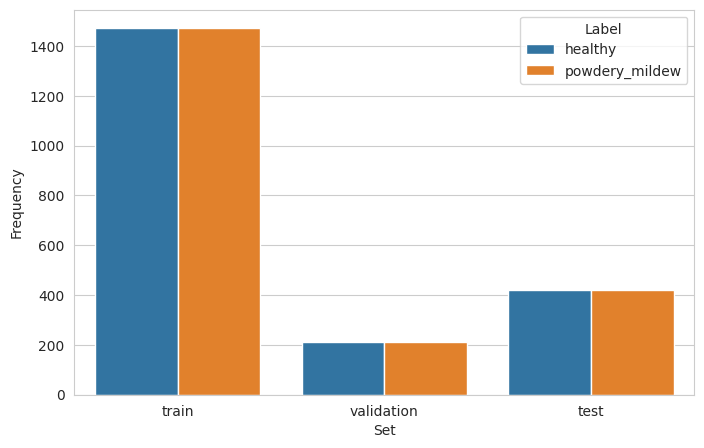

In [9]:
df_freq = pd.DataFrame([]) 
data = []  # Collect data in a list instead of appending directly

for folder in ['train', 'validation', 'test']:
    for label in labels:
        frequency = int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))
        data.append({'Set': folder, 'Label': label, 'Frequency': frequency})
        
        print(f"* {folder} - {label}: {frequency} images")

# Convert the collected data into a DataFrame
df_freq = pd.DataFrame(data)

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

## Image data augmentation

---

### ImageDataGenerator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-01-26 14:45:32.023221: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-26 14:45:32.026380: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-26 14:45:32.029218: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-26 14:45:32.041109: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737902732.056075    1517 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737902732.06

### Initialize ImageDataGenerator

In [11]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

### Augment training image dataset

In [12]:
batch_size = 20 # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True
                                              )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment validation image dataset

In [13]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment test image dataset

In [14]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False
                                                    )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented training image

In [15]:
! pip install scipy


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


(20, 256, 256, 3)


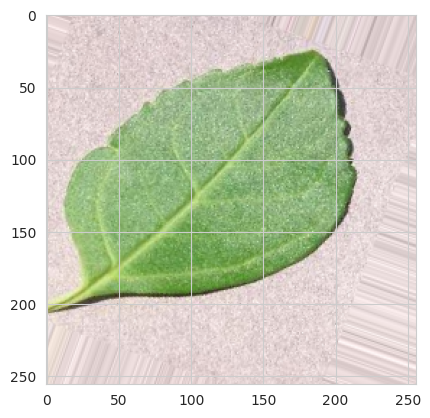

(20, 256, 256, 3)


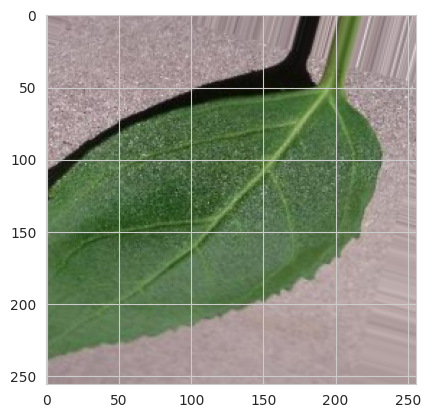

(20, 256, 256, 3)


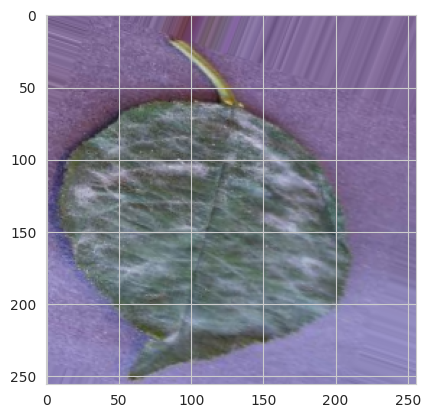

In [16]:
for _ in range(3):
    img, label = train_set.__next__()  # Directly calling the iterator method
    print(img.shape)  # Expected output: (1, 256, 256, 3)
    plt.imshow(img[0])
    plt.show()

## Plot augmented validation and test images

(20, 256, 256, 3)


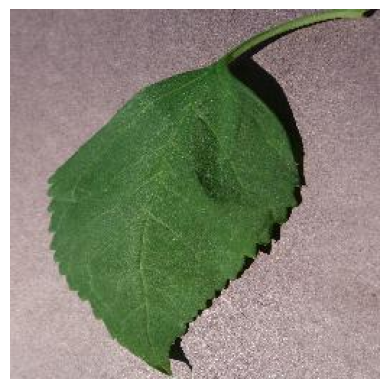

(20, 256, 256, 3)


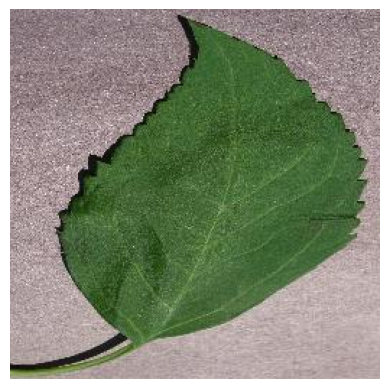

(20, 256, 256, 3)


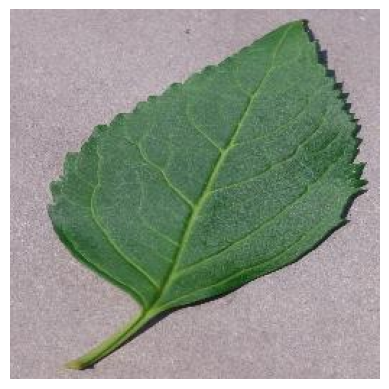

In [17]:
for _ in range(3):
    img, label = validation_set.__next__() 
    print(img.shape)  # Expected output: (batch_size, 256, 256, 3)

    plt.imshow(img[0])
    plt.axis('off')
    plt.show()


(20, 256, 256, 3)


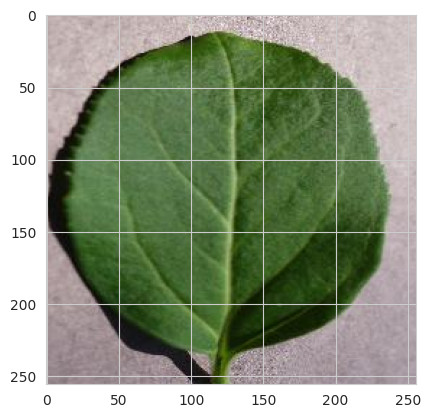

(20, 256, 256, 3)


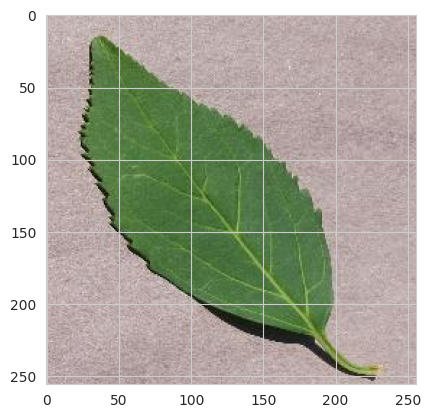

(20, 256, 256, 3)


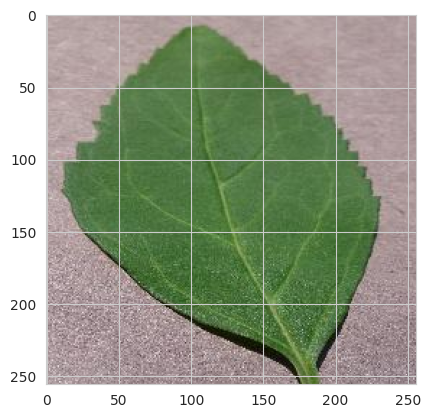

In [18]:
for _ in range(3):
    img, label = test_set.__next__()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Save class_indices

In [19]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

## Model creation

### ML Model

* #### Import model packages

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* #### Model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

def create_tf_model():
    model = Sequential()

    model.add(Input(shape=image_shape))

    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model


* #### Model Summary

In [22]:
create_tf_model().summary()

2025-01-26 14:45:36.817420: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,429,377 (28.34 MB)

 Trainable params: 7,429,377 (28.34 MB)

 Non-trainable params: 0 (0.00 B)

* #### Early Stopping

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)

### Fit model for model training

In [26]:
import math

steps_per_epoch = math.ceil(train_set.samples / batch_size)

model = create_tf_model()
model.fit(
    train_set,
    epochs=25,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_set,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 148s 988ms/step - accuracy: 0.6835 - loss: 0.5524 - val_accuracy: 0.9833 - val_loss: 0.0656
Epoch 2/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 136s 920ms/step - accuracy: 0.9894 - loss: 0.0499 - val_accuracy: 0.9595 - val_loss: 0.1421
Epoch 3/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 131s 886ms/step - accuracy: 0.9877 - loss: 0.0531 - val_accuracy: 0.9524 - val_loss: 0.2162
Epoch 4/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 137s 924ms/step - accuracy: 0.9749 - loss: 0.0911 - val_accuracy: 0.9881 - val_loss: 0.0544
Epoch 5/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 136s 919ms/step - accuracy: 0.9864 - loss: 0.0487 - val_accuracy: 0.9810 - val_loss: 0.0801
Epoch 6/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 134s 908ms/step - accuracy: 0.9950 - loss: 0.0214 - val_accuracy: 0.9905 - val_loss: 0.0298
Epoch 7/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 135s 911ms/step - accuracy: 0.9764 - loss: 0.0820 - val_accuracy: 0.9500 - val_loss: 0.1735
Epoch 8/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 137s 926ms/step - accuracy: 0.9883 -

### Save Model

In [27]:
model.save('outputs/v1/cherry_leaves_model.h5')

---

## Model Performance

### Model learning curve

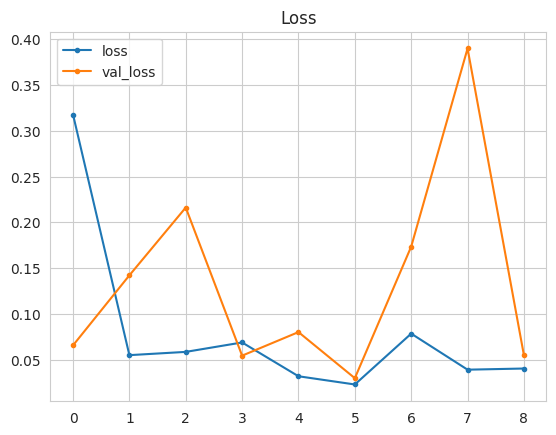

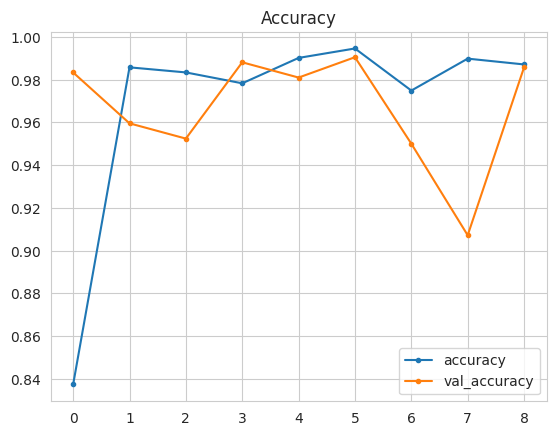

In [28]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

Evaluate model on test set.

* The performance on the test set meets the project requirements (at least 97% accuracy on the test set)

Load saved model

In [29]:
from keras.models import load_model
model = load_model('outputs/v1/cherry_leaves_model.h5')

#### Evaluate model accuracy on the test set

In [30]:
test_loss, test_accuracy = model.evaluate(test_set, verbose=1)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

/workspace/.pip-modules/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - accuracy: 0.9978 - loss: 0.0052
Test Accuracy: 99.53%


### Save evaluation pickle

In [32]:
evaluation = model.evaluate(validation_set, verbose=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.9960 - loss: 0.0105


In [33]:
joblib.dump(value=evaluation ,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

### Predict on new data
Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


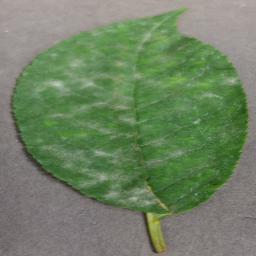

In [34]:
from tensorflow.keras.preprocessing import image
import random

label = random.choice(labels) 

pointer = random.randint(0, len(os.listdir(test_path + '/' + label)) - 1)

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path + '/' + label)[pointer],
                          target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [35]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Predict class probabilities

In [36]:
pred_proba = model.predict(my_image)[0,0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class =  target_map[pred_proba > 0.5]  

if pred_class == target_map[0]: pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
0.99981785
powdery_mildew


---

## Push files to Repo
### Push generated/new files from this session to GitHub repo
* .gitignore

In [1]:
!cat .gitignore

cat: .gitignore: No such file or directory


* Git status

In [4]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   ../README.md
	modified:   ../app_pages/page_cherryleaves_detector.py
	modified:   ../app_pages/page_cherryleaves_visualizer.py
	modified:   ../app_pages/page_ml_performance.py
	modified:   ../app_pages/page_summary.py
	modified:   ModellingandEvaluating.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


* Git add 

In [5]:
!git add .

* Git commit

In [6]:
!git commit -am " Add readme"

[main 19b4058]  Add readme
 6 files changed, 4452 insertions(+), 79 deletions(-)


* Git Push

In [7]:
!git push

Enumerating objects: 19, done.
Counting objects: 100% (19/19), done.
Delta compression using up to 32 threads
Compressing objects: 100% (10/10), done.
Writing objects: 100% (10/10), 90.74 KiB | 1.68 MiB/s, done.
Total 10 (delta 8), reused 0 (delta 0), pack-reused 0 (from 0)
remote: Resolving deltas: 100% (8/8), completed with 8 local objects.
To https://github.com/Katherine-Holland/NEW-CHERRY-LEAVES.git
   dfa5e99..19b4058  main -> main


---